Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')


/var/folders/ty/cy038g3n0b76wc7182ktv28r0000gn/T/ipykernel_68072/2000803505.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=station_activity['ride activity'], palette='coolwarm')


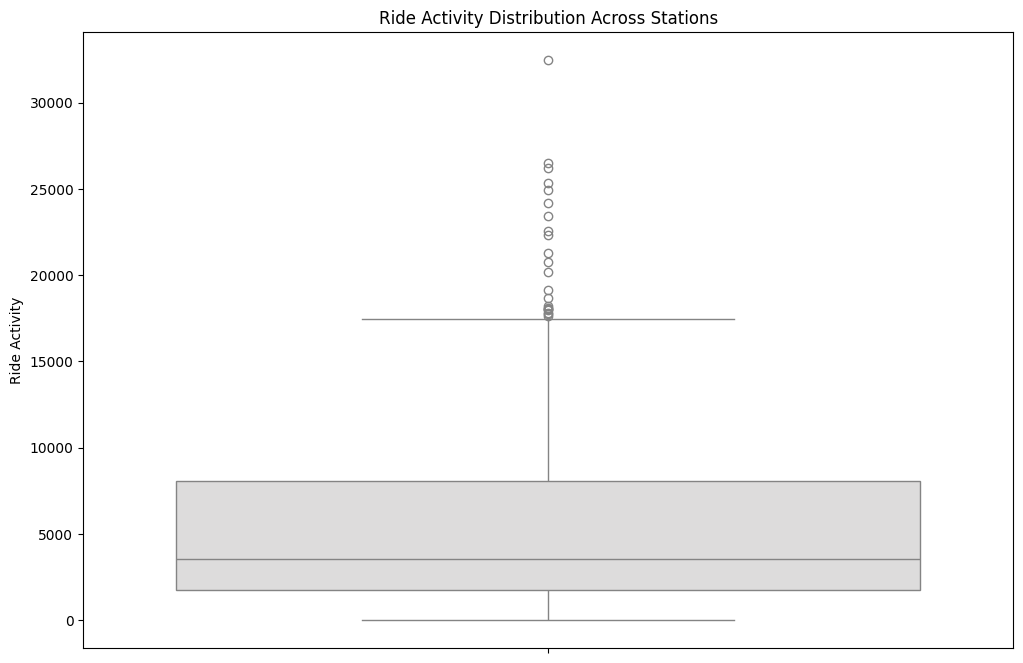

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# 获取所有 CSV 文件的路径
file_paths = glob.glob('./data/2019-citibike-tripdata/7_July/201907-citibike-tripdata_*.csv')

# 读取并合并所有 CSV 文件
dataframes = [pd.read_csv(file) for file in file_paths]
data = pd.concat(dataframes, ignore_index=True)
print(data.columns)

# 计算每个站点的开始和结束骑行次数
start_station_counts = data.groupby(['start station id', 'start station name']).size().reset_index(name='ride start count')
end_station_counts = data.groupby(['end station id', 'end station name']).size().reset_index(name='ride end count')

# 合并开始和结束骑行次数
station_activity = pd.merge(start_station_counts, end_station_counts,
                            left_on='start station id', right_on='end station id',
                            how='outer').fillna(0)

# 计算总骑行活动
station_activity['ride activity'] = station_activity['ride start count'] + station_activity['ride end count']

# 重命名列
station_activity = station_activity.rename(columns={
    'start station name': 'station name'
})

# 绘制纵向箱线图
plt.figure(figsize=(12, 8))
sns.boxplot(y=station_activity['ride activity'], palette='coolwarm')
plt.title('Ride Activity Distribution Across Stations')
plt.ylabel('Ride Activity')
plt.savefig('./map/ride_activity_distribution.png')
plt.show()


In [3]:
# 统计唯一的起始站点和结束站点的个数
unique_start_stations = data['start station id'].nunique()
unique_end_stations = data['end station id'].nunique()

# 打印结果
print(f"Unique start stations: {unique_start_stations}")
print(f"Unique end stations: {unique_end_stations}")

# 或者，如果你想统计所有站点的总数（不考虑起始或结束），可以合并后去重
all_stations = pd.concat([data['start station id'], data['end station id']]).nunique()
print(f"Total unique stations: {all_stations}")


Unique start stations: 787
Unique end stations: 800
Total unique stations: 800


In [4]:
import folium
import pandas as pd

# 提取起始和结束站点的信息
start_stations = data[['start station id', 'start station name', 'start station latitude', 'start station longitude']].drop_duplicates()
end_stations = data[['end station id', 'end station name', 'end station latitude', 'end station longitude']].drop_duplicates()

# 重命名结束站点的列以便合并
end_stations.columns = ['station id', 'station name', 'station latitude', 'station longitude']
start_stations.columns = ['station id', 'station name', 'station latitude', 'station longitude']

# 合并起始和结束站点
all_stations = pd.concat([start_stations, end_stations]).drop_duplicates()

# 创建地图，中心点为所有站点的平均位置
m = folium.Map(location=[all_stations['station latitude'].mean(), all_stations['station longitude'].mean()], zoom_start=13)

# 在地图上添加站点标记
for _, row in all_stations.iterrows():
    folium.Marker(
        location=[row['station latitude'], row['station longitude']],
        popup=row['station name'],
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

# 保存地图到 HTML 文件
m.save('map/stations_map.html')

# 打印站点总数
print(f"Total unique stations: {all_stations['station id'].nunique()}")


Total unique stations: 800


In [5]:
import geopandas as gpd

# 读取 Shapefile
shapefile_path = "./data/nyc2020_census/nyct2020.shp"
gdf = gpd.read_file(shapefile_path)

# 统计要素总数
total_features = len(gdf)

print(f"Total number of features: {total_features}")


Total number of features: 2325


In [6]:
import geopandas as gpd
import pandas as pd

# 读取普查区 Shapefile
census_gdf = gpd.read_file("./data/nyc2020_census/nyct2020.shp")

# 读取 Citibike 数据
citibike_df = pd.concat([
    pd.read_csv("./data/2019-citibike-tripdata/7_July/201907-citibike-tripdata_1.csv"),
    pd.read_csv("./data/2019-citibike-tripdata/7_July/201907-citibike-tripdata_2.csv"),
    pd.read_csv("./data/2019-citibike-tripdata/7_July/201907-citibike-tripdata_3.csv")
])

# 创建起始站点的 GeoDataFrame
start_station_gdf = gpd.GeoDataFrame(
    citibike_df,
    geometry=gpd.points_from_xy(citibike_df['start station longitude'], citibike_df['start station latitude']),
    crs="EPSG:4326"
)

# 创建终点站点的 GeoDataFrame
end_station_gdf = gpd.GeoDataFrame(
    citibike_df,
    geometry=gpd.points_from_xy(citibike_df['end station longitude'], citibike_df['end station latitude']),
    crs="EPSG:4326"
)

# 确保普查区和站点的 CRS 一致
census_gdf = census_gdf.to_crs(start_station_gdf.crs)

# 执行空间连接，找到每个起始站点所属的普查区
start_stations_in_census = gpd.sjoin(start_station_gdf, census_gdf, how="inner", op="within")

# 执行空间连接，找到每个终点站点所属的普查区
end_stations_in_census = gpd.sjoin(end_station_gdf, census_gdf, how="inner", op="within")

# 合并起始站和终点站的普查区
all_stations_in_census = pd.concat([
    start_stations_in_census['BoroCT2020'],
    end_stations_in_census['BoroCT2020']
]).drop_duplicates()

# 统计有数据的普查区数量
unique_census_with_data = all_stations_in_census.nunique()

print(f"Number of census tracts containing Citibike data: {unique_census_with_data}")


/Users/jiazhuangfeng/Documents/project/spatial_analysis/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/jiazhuangfeng/Documents/project/spatial_analysis/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Number of census tracts containing Citibike data: 441


In [10]:
all_stations_in_census
all_stations_in_census.to_csv('stations_07.txt', index=False, header=False)

/var/folders/ty/cy038g3n0b76wc7182ktv28r0000gn/T/ipykernel_75616/160242568.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=stations_df['number_of_stations'], palette='coolwarm')


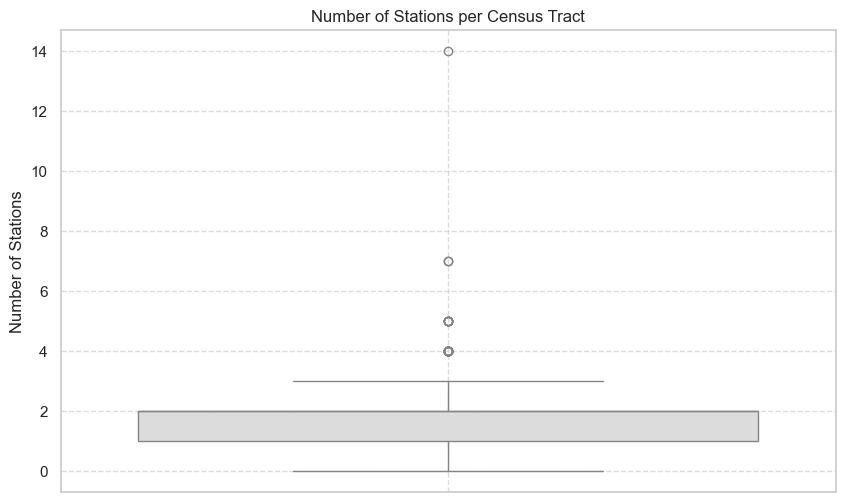

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# 应用 Seaborn 风格
sns.set(style="whitegrid")

# 确保 stations_per_census 是一个 Series
stations_per_census = all_stations_in_census.groupby('BoroCT2020')['station_id'].nunique()

# 将 Series 转换为 DataFrame
stations_df = stations_per_census.reset_index()

# 选择唯一的列
stations_df = stations_df.loc[:, ~stations_df.columns.duplicated()]

# 重命名列
stations_df.columns = ['BoroCT2020', 'number_of_stations']

# 绘制箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(y=stations_df['number_of_stations'], palette='coolwarm')
plt.title('Number of Stations per Census Tract')
plt.ylabel('Number of Stations')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('./map/station_and_census_distribution.png')
# 显示图形
plt.show()


/var/folders/ty/cy038g3n0b76wc7182ktv28r0000gn/T/ipykernel_75616/342465844.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=census_ride_activity['ride activity'], palette='coolwarm')


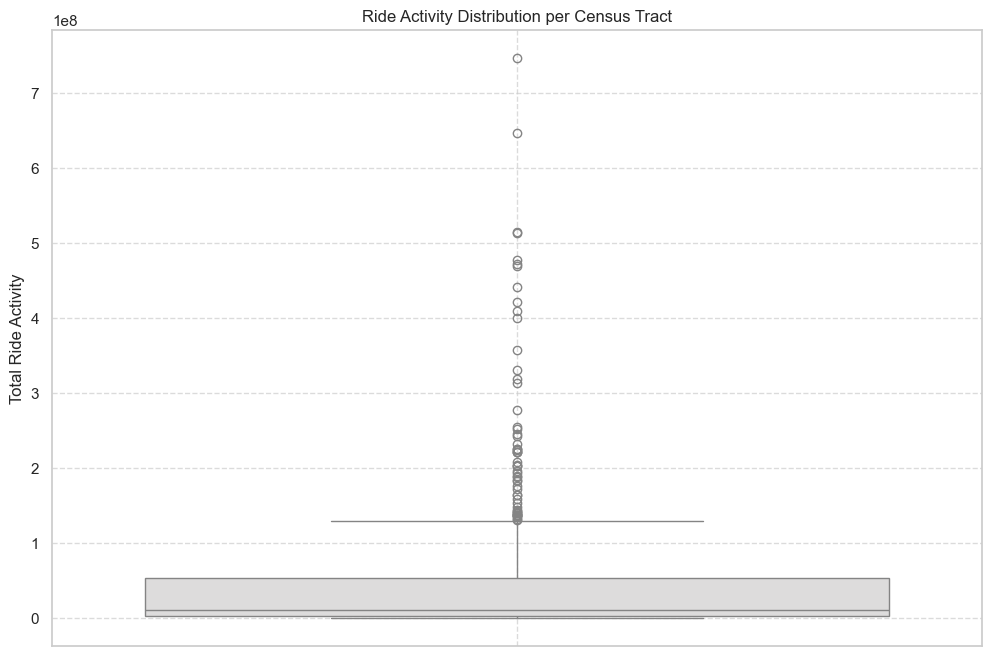

In [28]:
# 删除重复的 'station_id' 列
all_stations_in_census = all_stations_in_census.loc[:, ~all_stations_in_census.columns.duplicated()]

# 再次合并数据
merged_data = pd.merge(station_activity, all_stations_in_census, on='station_id', how='inner')

# 计算每个 Census Tract 的总骑行活动
census_ride_activity = merged_data.groupby('BoroCT2020')['ride activity'].sum().reset_index()

# 绘制骑行活动的箱线图
plt.figure(figsize=(12, 8))
sns.boxplot(y=census_ride_activity['ride activity'], palette='coolwarm')
plt.title('Ride Activity Distribution per Census Tract')
plt.ylabel('Total Ride Activity')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('./map/census_ride_activity_distribution.png')

# 显示图形
plt.show()

In [27]:
print(station_activity.columns)
print(all_stations_in_census.columns)


Index(['station_id', 'station name', 'ride start count', 'end station id',
       'end station name', 'ride end count', 'ride activity'],
      dtype='object')
Index(['station_id', 'BoroCT2020', 'station_id'], dtype='object')


/Users/jiazhuangfeng/Documents/project/spatial_analysis/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/ty/cy038g3n0b76wc7182ktv28r0000gn/T/ipykernel_75616/4040738825.py:32: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:2263

  station_census = gpd.sjoin(citibike_gdf, census_gdf, how='inner', op='within')
/var/folders/ty/cy038g3n0b76wc7182ktv28r0000gn/T/ipykernel_75616/4040738825.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd

Text(0.5, 1.0, 'Citibike Ride Activity by Census Tract (July 2019)')

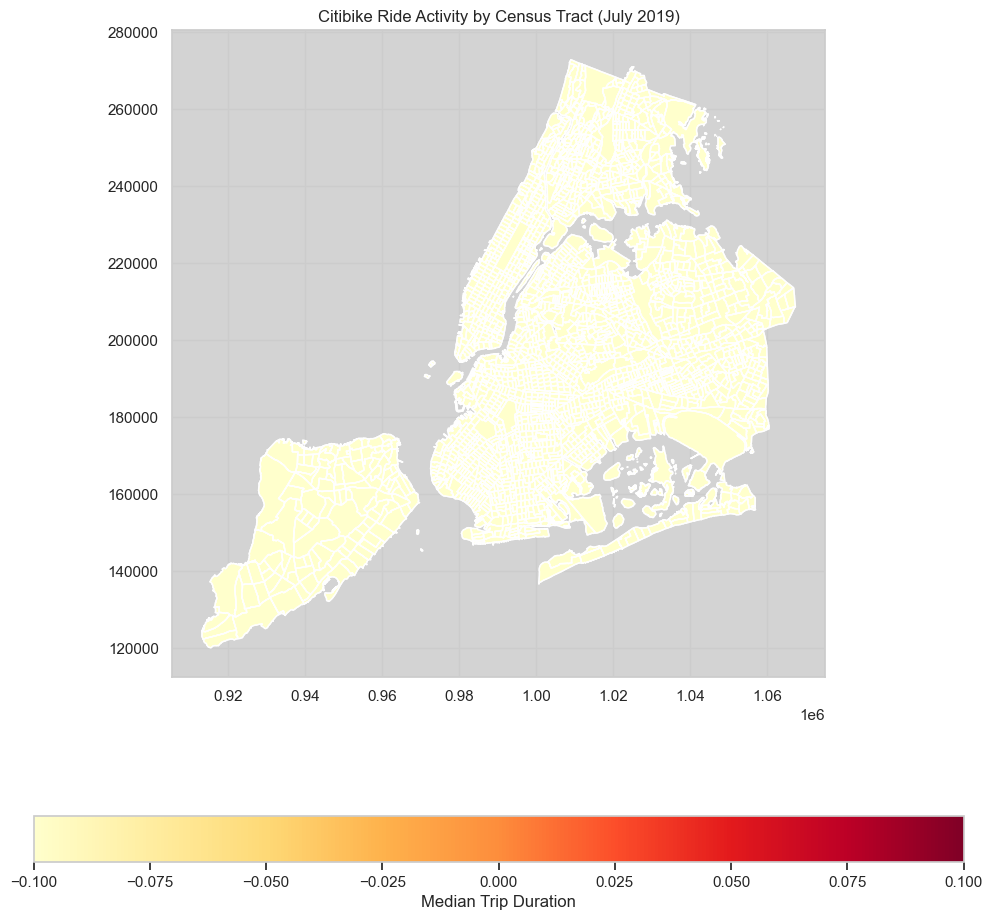

In [39]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from mapclassify import Quantiles

# 读取普查区 Shapefile
census_gdf = gpd.read_file("./data/nyc2020_census/nyct2020.shp")

# 读取 Citibike 数据
citibike_df = pd.concat([
    pd.read_csv("./data/2019-citibike-tripdata/7_July/201907-citibike-tripdata_1.csv"),
    pd.read_csv("./data/2019-citibike-tripdata/7_July/201907-citibike-tripdata_2.csv"),
    pd.read_csv("./data/2019-citibike-tripdata/7_July/201907-citibike-tripdata_3.csv")
])

# 转换时间列
citibike_df['starttime'] = pd.to_datetime(citibike_df['starttime'])
citibike_df['stoptime'] = pd.to_datetime(citibike_df['stoptime'])

# 计算骑行活动
citibike_df['ride_activity'] = 1  # 每次骑行计为一次活动

# 创建几何列
citibike_gdf = gpd.GeoDataFrame(
    citibike_df, 
    geometry=gpd.points_from_xy(citibike_df['start station longitude'], citibike_df['start station latitude']),
    crs="EPSG:4326"
)

# 聚合到普查区
station_census = gpd.sjoin(citibike_gdf, census_gdf, how='inner', op='within')
census_activity = station_census.groupby('BoroCT2020').agg({'ride_activity': 'sum'}).reset_index()

# 合并普查区数据
census_gdf = census_gdf.merge(census_activity, on='BoroCT2020', how='left').fillna(0)
census_gdf['quantiles'] = Quantiles(census_gdf['ride_activity'], k=5).yb

#  修改绘图代码
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
census_gdf.plot(column='quantiles', ax=ax, legend=True, cmap='YlOrRd', 
                legend_kwds={'label': "Median Trip Duration", 'orientation': "horizontal"})

# 设置背景颜色
ax.set_facecolor("lightgrey")

# 设置边界颜色
census_gdf.boundary.plot(ax=ax, linewidth=1, color="white")

# 设置标题
ax.set_title('Citibike Ride Activity by Census Tract (July 2019)')